In [19]:
import torch
import torch.nn as nn
import numpy as np

# Building UNet Architecture

<b>Convolutional block:</b><br>
It follows a two 3x3 convolutional layer, each followed by a batch normalization and a relu activation.

In [20]:
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

<b>Encoder block:</b><br>
It consists of an conv_block followed by a max pooling.
Here the number of filters doubles and the height and width half after every block.

In [21]:
class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p

<b>Decoder block:</b></br>
The decoder block begins with a transpose convolution, followed by a concatenation with the skipconnection from the encoder block. Next comes the conv_block.
Here the number filters decreases by half and the height and width doubles.

In [22]:
class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)

        return x

In [23]:
class build_unet(nn.Module):
    def __init__(self):
        super().__init__()

        """ Encoder """
        self.e1 = encoder_block(3, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)

        """ Bottleneck """
        self.b = conv_block(512, 1024)

        """ Decoder """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)

        """ Classifier """
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)
    
    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)
        b = self.b(p4)

        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        """ Classifier """
        outputs = self.outputs(d4)

        return outputs

In [24]:
model = build_unet()

In [9]:
inputs = torch.randn((1,3, 512,512))
y = model(inputs)
y.shape

torch.Size([1, 1, 512, 512])

# Importing Data

In [12]:
import cv2
import PIL
import tensorflow as tf
import keras
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
data_dir = tf.keras.utils.get_file('flower_photos', origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz', untar=True, cache_dir='.')
data_dir = pathlib.Path(data_dir)
data_dir

WindowsPath('datasets/flower_photos')

In [4]:
paths = list(data_dir.glob('*/*.jpg'))
paths

[WindowsPath('datasets/flower_photos/daisy/100080576_f52e8ee070_n.jpg'),
 WindowsPath('datasets/flower_photos/daisy/10140303196_b88d3d6cec.jpg'),
 WindowsPath('datasets/flower_photos/daisy/10172379554_b296050f82_n.jpg'),
 WindowsPath('datasets/flower_photos/daisy/10172567486_2748826a8b.jpg'),
 WindowsPath('datasets/flower_photos/daisy/10172636503_21bededa75_n.jpg'),
 WindowsPath('datasets/flower_photos/daisy/102841525_bd6628ae3c.jpg'),
 WindowsPath('datasets/flower_photos/daisy/1031799732_e7f4008c03.jpg'),
 WindowsPath('datasets/flower_photos/daisy/10391248763_1d16681106_n.jpg'),
 WindowsPath('datasets/flower_photos/daisy/10437754174_22ec990b77_m.jpg'),
 WindowsPath('datasets/flower_photos/daisy/10437770546_8bb6f7bdd3_m.jpg'),
 WindowsPath('datasets/flower_photos/daisy/10437929963_bc13eebe0c.jpg'),
 WindowsPath('datasets/flower_photos/daisy/10466290366_cc72e33532.jpg'),
 WindowsPath('datasets/flower_photos/daisy/10466558316_a7198b87e2.jpg'),
 WindowsPath('datasets/flower_photos/daisy/1

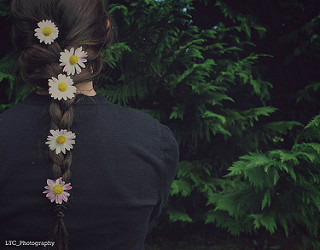

In [70]:
PIL.Image.open(paths[4])

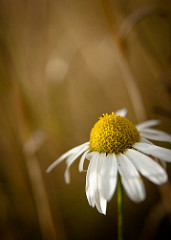

In [72]:
PIL.Image.open(paths[8])

In [6]:
img_code = cv2.imread(str(paths[64]))
img_code.shape

(333, 500, 3)

In [53]:
resized_img = []
for i in range(10):
    img_code = cv2.imread(str(paths[i]))
    resized_img_code = cv2.resize(img_code, (512, 512))
    resized_img.append(resized_img_code)
x = np.array(resized_img, dtype = 'float32')

In [56]:
x.shape

(10, 512, 512, 3)

In [57]:
x_tensor = torch.from_numpy(x.reshape((10, 3, 512, 512)))
x_tensor

tensor([[[[133., 135., 135.,  ..., 162., 167., 165.],
          [164., 168., 166.,  ..., 171., 171., 173.],
          [171., 171., 168.,  ..., 148., 148., 148.],
          ...,
          [164., 172.,  52.,  ..., 166., 164., 164.],
          [160., 155., 154.,  ..., 136., 101., 132.],
          [133.,  94., 128.,  ..., 169., 178.,  46.]],

         [[164., 173.,  50.,  ..., 166., 164., 164.],
          [160., 155., 154.,  ..., 137., 104., 132.],
          [133.,  96., 129.,  ..., 164., 175.,  28.],
          ...,
          [126.,  86., 123.,  ..., 119., 128.,  27.],
          [123., 129.,  59.,  ..., 145., 145., 145.],
          [115., 114., 116.,  ..., 126.,  92., 126.]],

         [[125.,  86., 123.,  ..., 120., 127.,  23.],
          [116., 122.,  55.,  ..., 146., 146., 146.],
          [113., 113., 115.,  ..., 125.,  89., 124.],
          ...,
          [ 26.,  47.,  44.,  ..., 175., 182., 177.],
          [176., 183., 177.,  ..., 124., 125., 116.],
          [124., 124., 118.,  ...

In [58]:
x_tensor.shape

torch.Size([10, 3, 512, 512])

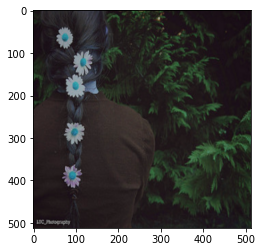

In [48]:
plt.imshow(x[4])

# Model Training

In [59]:
y = model(x_tensor)

In [60]:
y.shape

torch.Size([10, 1, 512, 512])

# Final Output

In [63]:
y_arr = y.detach().numpy()
y_arr = y_arr.reshape((10, 512,512, 1))

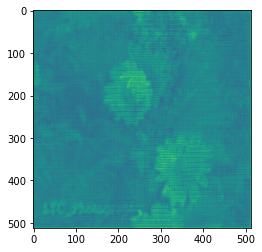

In [64]:
plt.imshow(y_arr[4])

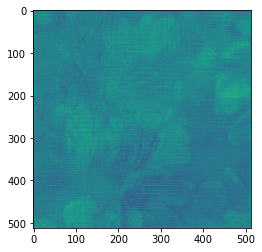

In [66]:
plt.imshow(y_arr[3])

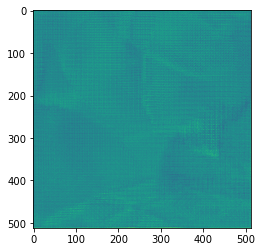

In [67]:
plt.imshow(y_arr[8])